In [170]:
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages

# from tabpfn import TabPFNClassifier
# TabPFNClassifier(N_ensemble_configurations = 64, device = 'cuda:0')

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [171]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

In [172]:
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pyprojroot import here

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier
from tabpfn import TabPFNClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

### Data Pull

In [174]:
# load data
local_dir = str(here()) + '/'
kaggle_dir = '/kaggle/input/'
train_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/greeks.csv')

# join greeks and add Epsilon
train_df.drop(['EJ'], axis = 1, inplace = True)
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['Id'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)
train_df = train_df[train_df['Epsilon'].notna()]
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])
train_df['Epsilon'] = train_df['Epsilon'].apply(lambda x: x.toordinal() - 734640)
train_df.reset_index(drop = True, inplace = True)

# Data Pre-Processing

In [175]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# create x and y train
X_train = train_df.drop(['Alpha', 'Beta', 'Delta', 'Gamma', 'Class'], axis = 1, inplace = False)
y_train_class = train_df['Class']

alpha_encoder = LabelEncoder()
y_train_alpha = alpha_encoder.fit_transform(train_df['Alpha'])
alpha_encoder = LabelEncoder()
y_train_beta = alpha_encoder.fit_transform(train_df['Alpha'])
alpha_encoder = LabelEncoder()
y_train_delta = alpha_encoder.fit_transform(train_df['Delta'])
alpha_encoder = LabelEncoder()
y_train_gamma = alpha_encoder.fit_transform(train_df['Gamma'])

In [176]:
# # gather time series data on alpha
# X_train['Weeks Since 1-1-2019'] = train_df['Weeks Since 1-1-2019'].copy()
# alpha_cols = ['Alpha_0', 'Alpha_1', 'Alpha_2', 'Alpha_3']
# rolling_means = [24]
# shift = 2

# alpha_time_df = pd.get_dummies(y_train_alpha, prefix = 'Alpha')
# alpha_time_df = pd.concat([X_train[['Weeks Since 1-1-2019']], alpha_time_df.astype(int)], axis = 1)

# alpha_time_df = alpha_time_df.groupby('Weeks Since 1-1-2019').sum()[alpha_cols]
# alpha_time_df['Count'] = alpha_time_df['Alpha_0'] + alpha_time_df['Alpha_1'] + alpha_time_df['Alpha_2'] + alpha_time_df['Alpha_3']

# alpha_time_df = alpha_time_df.reindex(range(min(X_train['Weeks Since 1-1-2019']), max(X_train['Weeks Since 1-1-2019']) + 1), fill_value = 0)

# for col in alpha_cols:
#     for rolling_mean in rolling_means:
#         col_name = col + '_Rolling_Mean_' + str(rolling_mean)
#         alpha_time_df[col_name] = alpha_time_df[col].shift(shift).rolling(rolling_mean).sum() / alpha_time_df['Count'].shift(shift).rolling(rolling_mean).sum()

# alpha_time_df.fillna(0, inplace = True)
# alpha_time_df.drop(alpha_cols + ['Count'], axis = 1, inplace = True)
# alpha_time_df.reset_index(drop = False, inplace = True)
# X_train = pd.merge(X_train, alpha_time_df, on = 'Weeks Since 1-1-2019')
# X_train.drop('Weeks Since 1-1-2019', axis = 1, inplace = True)

In [177]:
# impute data
median_imputer = SimpleImputer(strategy = 'median')
imputed = median_imputer.fit_transform(X_train)
X_train = pd.DataFrame(imputed, columns = X_train.columns, index = X_train.index)

In [178]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

In [179]:
def encode_y(y_train, y_test = None):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    if y_test is not None:
        y_test = le.transform(y_test)
        return y_train, y_test
    else:
        return y_train

### TSNE

In [180]:
class_color_map = {0: 'C0', 1: 'C1'}
alpha_color_map = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
gamma_color_map = {'M': 'C0', 'N': 'C1', 'H': 'C2', 'B': 'C3', 'A': 'C4', 'F': 'C5', 'G': 'C6', 'E': 'C7'}

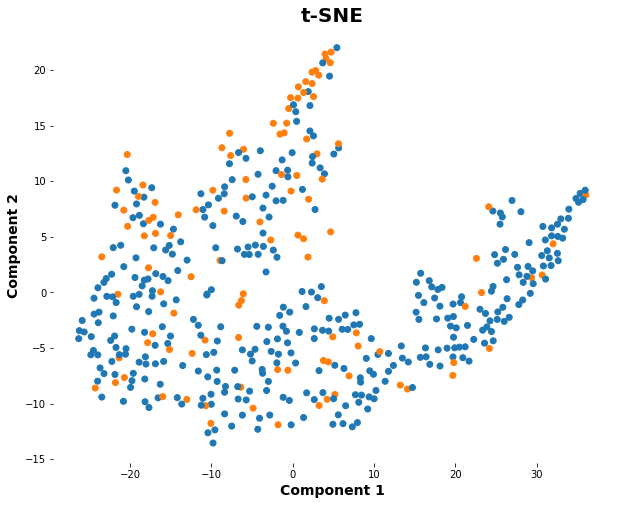

In [181]:
# t-SNE
tsne_n = 2
tsne = TSNE(n_components = tsne_n)
tsne_columns = ['Component ' + str(i + 1) for i in range(tsne_n)]
x_tsne = tsne.fit_transform(X_train)

# create df with the t-SNE components and 'Class'
tsne_df = pd.DataFrame(data = x_tsne, columns = tsne_columns)
tsne_df['Class'] = y_train_class

colors = train_df['Class'].map(class_color_map)

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()

In [182]:
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def get_closest_same_class(df, point):
    distances = []
    for i, row in df.iterrows():
        if i != point:
            dist = euclidean_distance([df.loc[point, 'Component 1'], df.loc[point, 'Component 2']], [row['Component 1'], row['Component 2']])
            distances.append((dist, i, row['Class']))
    distances.sort()  
    for i, (dist, idx, cls) in enumerate(distances):
        if cls == df.loc[point, 'Class']:
            return i, dist
    return -1, np.inf


In [183]:
tsne_neighbor = {}
tsne_neighbor_dist = {}
for i, row in tsne_df.iterrows():
    idx, dist = get_closest_same_class(tsne_df, i)
    tsne_neighbor[i] = idx
    tsne_neighbor_dist[i] = dist

tsne_df['TSNE Neighbor'] = pd.Series(tsne_neighbor)
tsne_df['TSNE Neighbor Distance'] = pd.Series(tsne_neighbor_dist)

# Meta Prediction Features

In [184]:
def fit_model(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    model.fit(X, y)
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index=X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    
    return predictions_df

In [185]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

## Greek Predictions

In [186]:
# models (ordered by performance)
svm = SVC(C = 5, gamma = 'auto', kernel = 'rbf', probability = True, random_state = random_seed)
tabpfn = TabPFNClassifier(N_ensemble_configurations = 24, seed = random_seed)
xgb = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5, random_state = random_seed)
xtree = ExtraTreesClassifier(criterion = 'log_loss', n_estimators = 250, max_depth = 9, min_samples_split = 3, max_features = 0.5, random_state = random_seed)
histboost = HistGradientBoostingClassifier(max_iter = 500, learning_rate = 0.2, min_samples_leaf = 50, random_state = random_seed)

# voting classifier
greek_voting_classifier = VotingClassifier(
    estimators = [('xgb', xgb), ('xtree', xtree), ('histboost', histboost)], 
    voting = 'soft'
)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [187]:
greek_prediction_cols = X_train.columns.to_list()

greeks = ['Alpha']
for greek in greeks:
    if greek == 'Alpha':
        y_train = y_train_alpha.copy()
    elif greek == 'Beta':
        y_train = y_train_beta.copy()
    elif greek == 'Delta':
        y_train = y_train_delta.copy()
    elif greek == 'Gamma':
        y_train = y_train_gamma.copy()
    elif greek == 'Class':
        y_train = y_train_class.copy()
        
    skf = StratifiedKFold(n_splits = 25, random_state = random_seed, shuffle = True)
    meta_prediction_features_df = pd.DataFrame({})
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        fold, oof = X_train.loc[train_index], X_train.loc[test_index]
        fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
        
        # fit voting classifier
        fold, fold_y = RandomOverSampler(random_state = random_seed).fit_resample(fold, fold_y)
        predictions_df = fit_model(greek, greek_voting_classifier, fold, fold_y, oof, greek_prediction_cols)
        meta_prediction_features_df = pd.concat([meta_prediction_features_df, predictions_df])
        
    X_train = pd.concat([X_train, meta_prediction_features_df], axis = 1)

In [188]:
test_df = pd.concat([X_train, tsne_df], axis = 1)

In [189]:
test_df['Error'] = abs(test_df['Class'] - test_df['Alpha_1'])

In [190]:
test_df

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GL,Epsilon,Alpha_0,Alpha_1,Component 1,Component 2,Class,TSNE Neighbor,TSNE Neighbor Distance,Error
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,0.120343,2497.0,0.115439,0.884561,-15.017475,5.109520,1,6,1.875335,0.115439
1,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,0.096614,2869.0,0.715233,0.284767,-0.206919,9.108136,1,3,1.571082,0.715233
2,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,5237.54088,...,21.978000,2693.0,0.992063,0.007937,19.409935,-3.033131,0,0,0.725762,0.007937
3,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,5710.46099,...,0.065096,2568.0,0.910833,0.089167,-18.055983,-6.449276,0,0,0.656907,0.089167
4,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,5040.77914,...,0.092873,2533.0,0.922981,0.077019,15.742999,1.717010,0,0,0.967937,0.077019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.175193,2607.26686,85.200147,7.067354,8.138688,4.030845,0.025578,3.396778,1.229900,6757.45461,...,21.978000,2947.0,0.987575,0.012425,1.334041,-11.258337,0,0,1.665489,0.012425
469,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,21.978000,3041.0,0.970102,0.029898,-0.591744,10.395970,0,0,0.594516,0.029898
470,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,0.145340,3036.0,0.906513,0.093487,-3.988976,12.738555,0,0,1.890145,0.093487
471,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,21.978000,2624.0,0.956918,0.043082,-8.390133,-8.985001,0,0,0.535059,0.043082


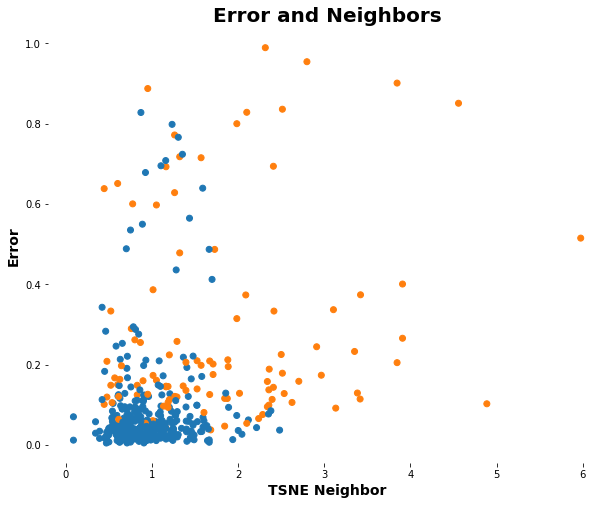

In [191]:
colors = test_df['Class'].map(class_color_map)

plt.figure(figsize = (10, 8))
plt.title('Error and Neighbors', fontdict = font_dict_header)
plt.box(False)
plt.scatter(test_df['TSNE Neighbor Distance'], test_df['Error'], c = colors)
plt.xlabel('TSNE Neighbor', fontdict = font_dict_axistitle)
plt.ylabel('Error', fontdict = font_dict_axistitle)

plt.show()

## Alpha Predictions

In [573]:
# gather time series data on alpha
X_train['Weeks Since 1-1-2019'] = train_df['Weeks Since 1-1-2019'].copy()
alpha_cols = ['Alpha_0', 'Alpha_1', 'Alpha_2', 'Alpha_3']
rolling_means = [24]
shift = 2

alpha_time_df = pd.get_dummies(y_train_alpha, prefix = 'Alpha')
alpha_time_df = pd.concat([X_train[['Weeks Since 1-1-2019']], alpha_time_df.astype(int)], axis = 1)

alpha_time_df = alpha_time_df.groupby('Weeks Since 1-1-2019').sum()[alpha_cols]
alpha_time_df['Count'] = alpha_time_df['Alpha_0'] + alpha_time_df['Alpha_1'] + alpha_time_df['Alpha_2'] + alpha_time_df['Alpha_3']

alpha_time_df = alpha_time_df.reindex(range(min(X_train['Weeks Since 1-1-2019']), max(X_train['Weeks Since 1-1-2019']) + 1), fill_value = 0)

for col in alpha_cols:
    for rolling_mean in rolling_means:
        col_name = col + '_Rolling_Mean_' + str(rolling_mean)
        alpha_time_df[col_name] = alpha_time_df[col].shift(shift).rolling(rolling_mean).sum() / alpha_time_df['Count'].shift(shift).rolling(rolling_mean).sum()

alpha_time_df.fillna(0, inplace = True)
alpha_time_df.drop(alpha_cols + ['Count'], axis = 1, inplace = True)
alpha_time_df.reset_index(drop = False, inplace = True)
X_train = pd.merge(X_train, alpha_time_df, on = 'Weeks Since 1-1-2019')
X_train.drop('Weeks Since 1-1-2019', axis = 1, inplace = True)

In [574]:
X_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Gamma_2,Gamma_3,Gamma_4,Gamma_5,Gamma_6,Gamma_7,Alpha_0_Rolling_Mean_24,Alpha_1_Rolling_Mean_24,Alpha_2_Rolling_Mean_24,Alpha_3_Rolling_Mean_24
0,-0.558848,-0.236450,-0.269977,-0.246707,-0.218848,-1.827988,-0.081263,-0.182438,-0.052735,-0.395860,...,0.001346,0.003460,0.369288,0.414687,0.065003,0.138858,0.783505,0.092784,0.000000,0.123711
1,0.232899,0.298631,0.647043,1.273756,-0.184504,1.068968,-0.081263,-0.476064,-0.110995,-0.210378,...,0.007530,0.006481,0.005508,0.072325,0.269222,0.570185,0.783505,0.092784,0.000000,0.123711
2,-0.075466,-0.140506,2.117003,-0.451509,-0.218848,-0.031334,-0.081263,0.093302,-0.110995,-0.271754,...,0.004340,0.002904,0.006433,0.063146,0.576741,0.309730,0.783505,0.092784,0.000000,0.123711
3,-0.225481,0.014720,-0.269977,-0.353351,-0.218848,-0.590782,-0.019649,-1.699753,1.248230,0.083465,...,0.009616,0.018354,0.001824,0.016942,0.311556,0.637470,0.754386,0.210526,0.035088,0.000000
4,-0.558848,-0.434973,-0.269977,-0.424898,-0.218848,-0.563739,-0.081263,0.464433,-0.110995,-0.063489,...,0.008043,0.001878,0.000550,0.001400,0.979318,0.002184,0.728070,0.175439,0.035088,0.061404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-0.483841,0.533236,-0.129027,-0.074451,-0.218848,-0.205422,-0.024784,0.154412,-0.040951,-0.188505,...,0.001017,0.001688,0.000685,0.002680,0.985832,0.001875,0.675676,0.216216,0.000000,0.108108
469,-0.400499,1.185037,0.366915,0.849172,-0.218848,-0.513034,-0.081263,0.023249,0.022467,0.170974,...,0.003023,0.004714,0.006606,0.026070,0.923000,0.028230,1.000000,0.000000,0.000000,0.000000
470,-0.175476,-0.751060,-0.269977,0.042989,0.098834,0.629523,-0.081263,0.518091,-0.110995,-0.425851,...,0.005292,0.009260,0.001954,0.002065,0.917913,0.002594,0.538462,0.384615,0.000000,0.076923
471,0.032879,-0.981727,-0.269977,-0.189581,-0.218848,0.193459,0.065070,1.178376,0.002306,0.073425,...,0.007740,0.003282,0.000668,0.002178,0.967208,0.002142,0.538462,0.384615,0.000000,0.076923


In [183]:
def scale_and_impute(X_train, X_test = None):
    X = X_train.copy()
    X_columns = X.columns
    X_index = X.index

    standard_scaler = StandardScaler()
    X = standard_scaler.fit_transform(X)
    knn_imputer = KNNImputer()
    X = knn_imputer.fit_transform(X)
    
    X = pd.DataFrame(X, columns = X_columns, index = X_index)
    
    if X_test is not None:
        X_t = X_test.copy()
        X_t_columns = X_t.columns
        X_t_index = X_t.index

        X_t = standard_scaler.transform(X_test)
        X_t = knn_imputer.transform(X_t)

        X_t = pd.DataFrame(X_test, columns = X_t_columns, index = X_t_index)
        return X, X_t
    else:
        
        return X

In [184]:
# models (ordered by performance)
tabpfn24 = TabPFNClassifier(N_ensemble_configurations = 24, seed = random_seed)
tabpfn128 = TabPFNClassifier(N_ensemble_configurations = 128, seed = random_seed)
catboost = CatBoostClassifier(depth = 6, iterations = 100, learning_rate = 0.05, loss_function = 'Logloss', auto_class_weights = 'Balanced', verbose = False, random_seed = random_seed)
xtree = ExtraTreesClassifier(criterion = 'log_loss', n_estimators = 250, max_depth = 9, min_samples_split = 3, max_features = 0.5, random_state = random_seed)
xgb = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 150, learning_rate = 0.02, max_depth = 3, gamma = 0.1, subsample = 0.7, random_state = random_seed)

# voting classifier
alpha_voting_classifier = VotingClassifier(
    estimators = [('tabpfn24', tabpfn24), ('catboost', catboost), ('xgb', xgb)],
    voting = 'soft',
    weights = [2, 1, 1]
)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [185]:
greek_prediction_cols = X_train.columns.to_list()
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
meta_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_class)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    
    # fit voting classifier
    predictions_df = fit_model('Class', alpha_voting_classifier, fold, fold_y, oof, greek_prediction_cols)
    meta_prediction_features_df = pd.concat([meta_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, meta_prediction_features_df], axis = 1)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [222]:
X_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Delta_2,Delta_3,Gamma_0,Gamma_1,Gamma_2,Gamma_3,Gamma_4,Gamma_5,Gamma_6,Gamma_7
0,-0.558848,-0.236450,-0.269977,-0.246707,-0.218848,-1.827988,-0.081263,-0.182438,-0.052735,-0.395860,...,0.558148,0.173441,0.005735,0.004684,0.011535,0.006410,0.041064,0.594654,0.289820,0.046099
1,-0.225481,0.014720,-0.269977,-0.353351,-0.218848,-0.590782,-0.019649,-1.699753,1.248230,0.083465,...,0.009461,0.005964,0.003396,0.004055,0.042394,0.174429,0.013814,0.135212,0.303479,0.323222
2,-0.558848,-0.434973,-0.269977,-0.424898,-0.218848,-0.563739,-0.081263,0.464433,-0.110995,-0.063489,...,0.004144,0.000656,0.000118,0.000255,0.000267,0.000186,0.000169,0.000385,0.998433,0.000187
3,-0.287987,-0.790047,-0.269977,-0.427010,0.564196,-1.364881,-0.081263,-0.954510,-0.110995,0.077998,...,0.008932,0.006830,0.005735,0.004759,0.004748,0.002474,0.003837,0.016132,0.950702,0.011613
4,-0.442170,-1.098849,-0.269977,-0.262403,-0.218848,-0.191901,-0.081263,-0.277829,-0.110995,-0.122355,...,0.012041,0.006835,0.000831,0.000663,0.000602,0.002271,0.008651,0.026482,0.414475,0.546024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-0.625522,-0.438413,-0.269977,-0.443861,-0.218848,-0.556978,-0.081263,-1.699753,-0.110995,0.391235,...,0.003411,0.000413,0.001666,0.000414,0.001425,0.003331,0.000376,0.000444,0.983771,0.008573
469,-0.675527,-0.227986,0.071075,-0.412389,0.314057,-0.759799,0.027845,-0.482026,-0.089792,-0.386557,...,0.002012,0.000117,0.001842,0.009748,0.000373,0.005360,0.000569,0.001530,0.977048,0.003530
470,-0.117137,0.710646,-0.269977,0.064023,0.636319,0.186698,-0.080621,0.482319,-0.076683,0.061129,...,0.005129,0.004377,0.000401,0.001070,0.006854,0.002499,0.003133,0.021715,0.948407,0.015921
471,-0.133805,-0.498048,0.127455,0.177279,-0.015074,0.984460,-0.081263,1.141114,-0.110995,0.131376,...,0.221076,0.041309,0.006811,0.012752,0.018132,0.005886,0.002687,0.016044,0.927889,0.009800


In [52]:
X_train['Alpha_0']

,Alpha_0,Alpha_0
0,0.231880,0.087340
1,0.737400,0.353925
2,0.981673,0.999184
3,0.943728,0.996105
4,0.945399,0.977992
...,...,...
468,0.976709,0.994739
469,0.969083,0.996741
470,0.938840,0.988372
471,0.950616,0.975715


In [106]:
y_pred_0 = np.array(X_train['Alpha_0'])
y_pred_1 = 1 - y_pred_0
y_pred = np.array([y_pred_0, y_pred_1]).T
y_pred_class_0 = y_pred_0.sum()
y_pred_class_1 = y_pred_1.sum()
new_probabilities = y_pred * np.array([[1/(y_pred_class_0 if i==0 else y_pred_class_1) for i in range(y_pred.shape[1])]])
y_pred = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)

y_pred = y_pred[:, 1]



y_true = y_train_class

In [107]:

max_pred = [
    0.75, 0.76, 0.77, 0.78, 0.79, 
    0.80, 0.81, 0.82, 0.83, 0.84, 
    0.85, 0.86, 0.87, 0.88, 0.89, 
    0.90, 0.91, 0.92, 0.93, 0.94, 
    0.95, 0.96, 0.97, 0.98, 0.99,
    1.00
]
min_pred = [
    0.00, 0.01, 0.02, 0.03, 0.04, 
    0.05, 0.06, 0.07, 0.08, 0.09, 
    0.10, 0.11, 0.12, 0.13, 0.14, 
    0.15, 0.16, 0.17, 0.18, 0.19, 
    0.20, 0.21, 0.22, 0.23, 0.24, 
    0.25
]

optimal_thresholds = pd.DataFrame({}, columns = ['Max', 'Min', 'Log Loss'])
for max_v in max_pred:
    for min_v in min_pred:
        fold_pred = y_pred.copy()
        fold_true = y_true.copy()
        
        fold_pred[fold_pred > max_v] = 1
        fold_pred[fold_pred < min_v] = 0
        
        loss = competition_log_loss(fold_true, fold_pred)
        
        # add to dataframe
        new_row = pd.DataFrame({'Max': [max_v], 'Min': [min_v], 'Log Loss': [loss]})
        optimal_thresholds = pd.concat([optimal_thresholds, new_row], ignore_index = True)
        
optimal_thresholds.groupby(['Max', 'Min']).mean().sort_values('Log Loss', ascending = True).head(10)

,,Log Loss
Max,Min,
0.95,0.0,0.238418
0.96,0.0,0.240071
0.97,0.0,0.240910
0.98,0.0,0.241998
0.99,0.0,0.242555
1.00,0.0,0.242877
0.93,0.0,0.279024
0.94,0.0,0.279952
0.90,0.0,0.359912


In [663]:
from lightgbm import LGBMClassifier

In [665]:
lgbm = LGBMClassifier()

In [666]:
lgbm.fit(X_train, y_train_class)

In [644]:
y_pred_filter = np.where(y_pred > 0.5, 1, 0)

In [199]:
X_train['Class True'] = y_true

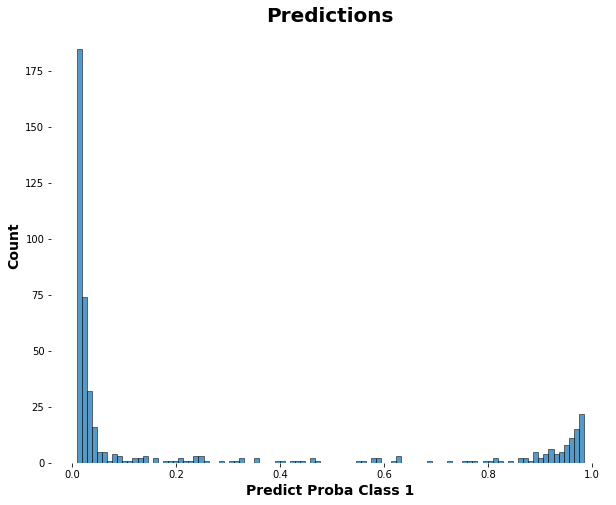

In [201]:
# histogram of class_1

plt.figure(figsize = (10, 8))
plt.title('Predictions', fontdict = font_dict_header)
sns.histplot(y_pred, bins = 100, kde = False)
plt.box(False)
plt.xlabel('Predict Proba Class 1', fontdict = font_dict_axistitle)
plt.ylabel('Count', fontdict = font_dict_axistitle)
plt.box(False)
plt.show()

In [200]:
X_train[y_pred_filter != y_true].sort_values(by = 'Class_1', ascending = False)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Gamma_1,Gamma_2,Gamma_3,Gamma_4,Gamma_5,Gamma_6,Gamma_7,Class_0,Class_1,Class True
223,1.366348,0.215393,-0.269977,0.161265,-0.218848,-0.019503,-0.081263,-1.699753,-0.031249,-0.570997,...,0.003848,0.009832,0.008957,0.023073,0.692566,0.165213,0.094254,0.039213,0.960787,0
83,-0.025461,0.646299,-0.269977,0.271614,0.105703,-0.323734,-0.081263,0.492752,-0.110995,-0.517184,...,0.028355,0.081572,0.026443,0.025098,0.372832,0.433164,0.016061,0.057962,0.942038,0
274,7.375293,1.456133,-0.269977,7.575668,5.375512,0.551775,-0.081263,1.944486,-0.064946,-0.048582,...,0.016975,0.010475,0.023050,0.015140,0.722701,0.144329,0.038090,0.106641,0.893359,0
429,-0.417167,-0.895805,0.260625,-0.299969,-0.218848,0.436844,-0.063292,0.251293,-0.052073,0.138254,...,0.007294,0.014439,0.009960,0.041261,0.208131,0.657841,0.056648,0.107978,0.892022,0
214,-0.300489,-0.874109,-0.269977,-0.135442,-0.218848,-0.012742,-0.081263,1.319972,0.013380,1.250454,...,0.006751,0.007964,0.007262,0.103658,0.334310,0.232220,0.303003,0.195976,0.804024,0
158,0.066215,0.110532,-0.269977,-0.207428,-0.218848,-0.070208,-0.081263,1.009951,-0.053161,-0.170546,...,0.004412,0.009566,0.011380,0.223634,0.163715,0.478912,0.103821,0.207442,0.792558,0
354,-0.808874,-0.938208,-0.269977,-0.439479,-0.218848,-0.949098,-0.081263,-0.885202,-0.097175,-0.315750,...,0.025407,0.013532,0.027750,0.011426,0.121546,0.742342,0.045587,0.225079,0.774921,0
402,0.466256,1.046601,0.368225,0.250062,-0.218848,-0.104012,-0.081263,1.331896,-0.110995,-0.657289,...,0.000994,0.001729,0.002846,0.023018,0.460280,0.070127,0.437892,0.236150,0.763850,0
173,-0.267152,-0.290311,0.151717,-0.234596,-0.194235,0.866148,0.007307,0.222974,-0.076825,0.771291,...,0.003928,0.005349,0.003170,0.028069,0.187145,0.686955,0.083637,0.242889,0.757111,0
278,-0.433836,2.111286,-0.269977,0.127881,0.300033,0.646425,-0.047247,-0.121328,-0.110995,-0.172131,...,0.019510,0.018423,0.013589,0.018680,0.134037,0.765768,0.020475,0.309874,0.690126,0


In [165]:
optimal_thresholds.groupby(['Max', 'Min']).mean().sort_values('Log Loss', ascending = True).head(10)

Log Loss
Max  Min           
0.99 0.02  0.210923
     0.01  0.210923
     0.00  0.210923
1.00 0.02  0.211928
     0.00  0.211928
     0.01  0.211928
0.98 0.02  0.250503
     0.01  0.250503
     0.00  0.250503
0.96 0.01  0.289752

In [139]:


parameters = {
    'weights': [
        [1, 1, 1, 1, 1],
        [1, 2, 2, 1, 1],
        [1, 2, 2, 1, 2],
        [3, 3, 2, 2, 2]
    ]
}

grid_obj = GridSearchCV(alpha_voting_classifier, parameters, scoring = balanced_log_loss_scorer, cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
alpha_voting_classifier = grid_obj.best_estimator_
alpha_voting_classifier.fit(X_train, y_train_class)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Tr

VotingClassifier(estimators=[('tabpfn24',
                              TabPFNClassifier(N_ensemble_configurations=24,
                                               seed=101010)),
                             ('tabpfn128',
                              TabPFNClassifier(N_ensemble_configurations=128,
                                               seed=101010)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x2ee6ea160>),
                             ('xtree',
                              ExtraTreesClassifier(criterion='log_loss',
                                                   max_depth=9,
                                                   max_features=0.5,
                                                   min_samples_split=3,
                                                   n_estima...
                                            interaction_constraints=None,
                                            learning_rate=0.02, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=150, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=101010,
                                            reg_alpha=None, reg_lambda=None, ...))],
                 voting='soft', weights=[1, 2, 2, 1, 1])

In [140]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.742723,0.052200,9.125715,0.130979,"[1, 2, 2, 1, 1]","{'weights': [1, 2, 2, 1, 1]}",-0.256125,-0.261528,-0.216527,-0.244727,0.020062,1
2,0.729505,0.019219,9.142061,0.107044,"[1, 2, 2, 1, 2]","{'weights': [1, 2, 2, 1, 2]}",-0.264303,-0.257397,-0.214064,-0.245255,0.022235,2
0,0.830699,0.044380,9.545078,0.092329,"[1, 1, 1, 1, 1]","{'weights': [1, 1, 1, 1, 1]}",-0.263803,-0.261149,-0.217812,-0.247588,0.021083,3
3,0.739267,0.035688,9.222489,0.161140,"[3, 3, 2, 2, 2]","{'weights': [3, 3, 2, 2, 2]}",-0.262784,-0.265446,-0.221663,-0.249965,0.020041,4


In [125]:
knn = KNeighborsClassifier(n_neighbors = 13, weights = 'distance', p = 1)
svm = SVC(C = 3, gamma = 'auto', kernel = 'rbf', probability = True, random_state = random_seed)
tabpfn = TabPFNClassifier(N_ensemble_configurations = 24, seed = random_seed)
histboost = HistGradientBoostingClassifier(max_iter = 50, learning_rate = 0.07, min_samples_leaf = 20, random_state = random_seed)
xgb = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 150, learning_rate = 0.02, max_depth = 3, gamma = 0.1, subsample = 0.7, random_state = random_seed)
xtree = ExtraTreesClassifier(criterion = 'log_loss', n_estimators = 250, max_depth = 9, min_samples_split = 3, max_features = 0.5, random_state = random_seed)
catboost = CatBoostClassifier(depth = 6, iterations = 100, learning_rate = 0.05, loss_function = 'Logloss', auto_class_weights = 'Balanced', verbose = False, random_seed = random_seed)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [134]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_class)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    
    
    model_features = X_train.columns.to_list()
    # KNN
    knn_features = ['Beta_0', 'Beta_1', 'Beta_3', 'Gamma_0', 'Gamma_1', 'Gamma_5', 'DU', 'FL', 'AY', 'EJ', 'DL', 'Days Since 1-1-2019']
    fold_scaled, oof_scaled = scale_and_impute(fold[knn_features], oof[knn_features])
    
    knn_predictions = fit_model('KNN 7', knn, fold_scaled, fold_y, oof_scaled, knn_features)
    
    svm_predictions = fit_model('SVM', svm, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN', tabpfn, fold, fold_y, oof, model_features)
    histboost_predictions = fit_model('HistBoost', histboost, fold, fold_y, oof, model_features)
    xgb_predictions = fit_model('XGB', xgb, fold, fold_y, oof, model_features)
    xtree_predictions = fit_model('Xtree', xtree, fold, fold_y, oof, model_features)
    catboost_predictions = fit_model('CatBoost', catboost, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([
        tabpfn_predictions, histboost_predictions,
        xgb_predictions, catboost_predictions
    ], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])

In [135]:
# keep _1 columns 
model_prediction_features_df = model_prediction_features_df[[col for col in model_prediction_features_df.columns if '_1' in col]]


In [136]:
model_prediction_features_df.corr().mean().sort_values(ascending = False)

XGB_1          0.987917
CatBoost_1     0.983311
HistBoost_1    0.982724
TabPFN_1       0.981748
dtype: float64

In [75]:
knn_features = ['Beta_0', 'Beta_1', 'Beta_3', 'Gamma_0', 'Gamma_1', 'Gamma_5', 'DU', 'FL', 'AY', 'EJ', 'DL', 'Days Since 1-1-2019']

In [98]:
knn = KNeighborsClassifier()

parameters = {
    'n_neighbors': [13],
    'weights': ['distance'],
    'p': [1]
}

grid_obj = GridSearchCV(knn, parameters, scoring = 'roc_auc_ovr_weighted', cv = 3)
grid_obj = grid_obj.fit(X_train[knn_features], y_train_alpha)
knn = grid_obj.best_estimator_
knn.fit(X_train[knn_features], y_train_alpha)

KNeighborsClassifier(n_neighbors=13, p=1, weights='distance')

In [99]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.000817,0.000108,0.002438,0.000019,13,1,distance,"{'n_neighbors': 13, 'p': 1, 'weights': 'distan...",0.932600,0.931431,0.937852,0.933961,0.002792,1
3,0.001025,0.000204,0.002456,0.000201,15,1,distance,"{'n_neighbors': 15, 'p': 1, 'weights': 'distan...",0.929149,0.929533,0.936002,0.931561,0.003144,2
1,0.000827,0.000202,0.002305,0.000214,11,1,distance,"{'n_neighbors': 11, 'p': 1, 'weights': 'distan...",0.922240,0.927368,0.939817,0.929808,0.007380,3
0,0.000932,0.000199,0.002561,0.000377,7,1,distance,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.911267,0.929129,0.942006,0.927467,0.012604,4


In [575]:
xgb = XGBClassifier(random_state = random_seed)

parameters = {
    'booster': ['gbtree'],
    'tree_method': ['hist']
}

grid_obj = GridSearchCV(xgb, parameters, scoring = balanced_log_loss_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train_class)
xgb = grid_obj.best_estimator_
xgb.fit(X_train, y_train_class)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=101010, reg_alpha=0, reg_lambda=1, ...)

In [576]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.126399,0.015051,0.00226,0.00017,gbtree,hist,"{'booster': 'gbtree', 'tree_method': 'hist'}",-1.399415,-1.4474,-1.422431,-1.674718,-1.723698,-1.533532,0.137001,1


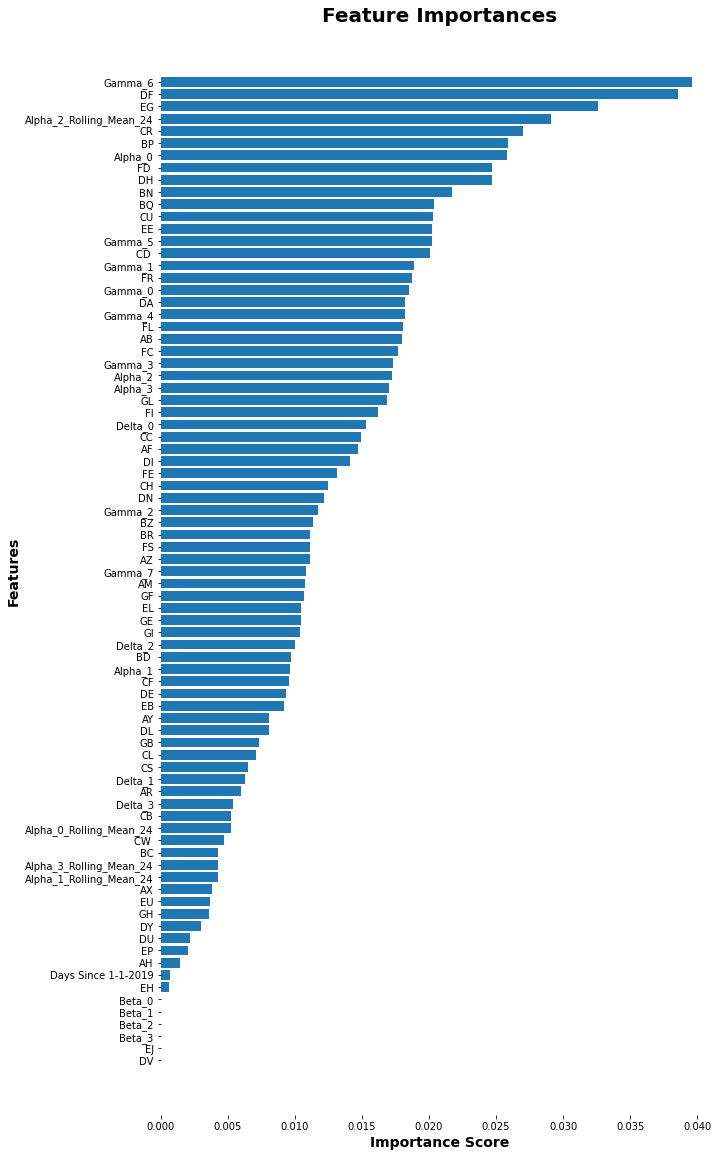

In [577]:
# plot feature importances
importances = pd.Series(xgb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [587]:
xtree = ExtraTreesClassifier(random_state = random_seed)

parameters = {
    'criterion': ['log_loss'],
    'n_estimators': [250]
}

grid_obj = GridSearchCV(xtree, parameters, scoring = 'roc_auc', cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
xtree = grid_obj.best_estimator_
xtree.fit(X_train, y_train_class)

ExtraTreesClassifier(criterion='log_loss', n_estimators=250,
                     random_state=101010)

In [588]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.169128,0.005886,0.011801,0.000227,log_loss,250,"{'criterion': 'log_loss', 'n_estimators': 250}",0.598588,0.535178,0.550046,0.561271,0.027077,1


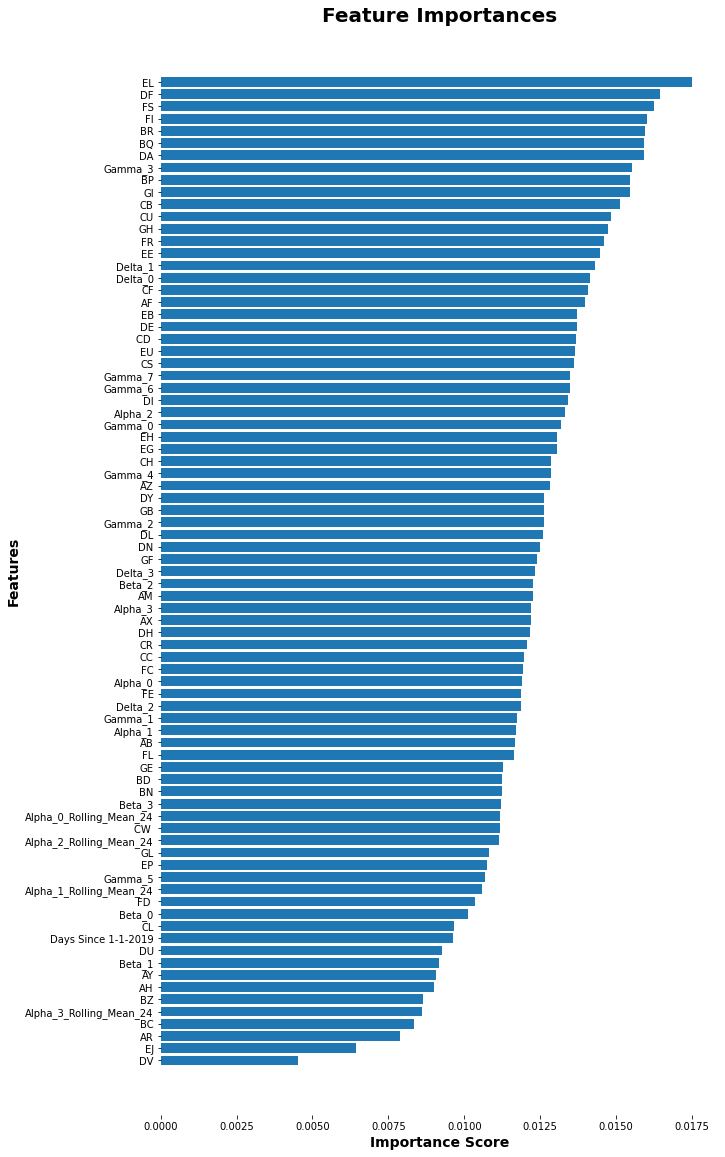

In [581]:
# plot feature importances
importances = pd.Series(xtree.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [370]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Initialize DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = random_seed)

# Define the parameter grid
parameters = {
    'criterion': ['gini'],
    'splitter': ['random'],
    'max_depth': [None, 1, 2, 3, 6],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': [None],
    'class_weight': ['balanced']
}

# Create a GridSearchCV object
grid_obj = GridSearchCV(dtc, parameters, scoring = balanced_log_loss_scorer, cv = 3)

# Fit the GridSearchCV object to the data
grid_obj = grid_obj.fit(X_train, y_train_class)

# Get the best estimator
dtc = grid_obj.best_estimator_

# Fit the best estimator to the data
dtc.fit(X_train, y_train_class)


DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                       min_samples_leaf=16, random_state=101010,
                       splitter='random')

In [371]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
148,0.001208,0.000027,0.000862,0.000013,balanced,gini,2,None,16,40,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
146,0.001243,0.000043,0.000860,0.000009,balanced,gini,2,None,16,20,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
144,0.001320,0.000074,0.000900,0.000047,balanced,gini,2,None,16,10,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
140,0.001224,0.000036,0.000859,0.000010,balanced,gini,2,None,16,2,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
142,0.001270,0.000043,0.000914,0.000038,balanced,gini,2,None,16,5,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-0.440767,-0.224232,-0.355251,-0.340083,0.089048,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,0.006554,0.000550,0.001110,0.000038,balanced,gini,None,None,2,5,best,"{'class_weight': 'balanced', 'criterion': 'gin...",-6.446114,-7.165320,-5.660568,-6.424001,0.614512,246
0,0.002420,0.000291,0.001174,0.000082,balanced,gini,None,None,1,2,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-6.833833,-8.980711,-4.785159,-6.866568,1.712983,247
2,0.002584,0.000537,0.001134,0.000049,balanced,gini,None,None,1,5,random,"{'class_weight': 'balanced', 'criterion': 'gin...",-6.433321,-8.758703,-5.767371,-6.986465,1.282314,248
3,0.007201,0.000265,0.001428,0.000047,balanced,gini,None,None,1,5,best,"{'class_weight': 'balanced', 'criterion': 'gin...",-7.377855,-8.697606,-5.656977,-7.244146,1.244927,249


In [227]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
76,0.058259,0.007870,0.002018,0.000101,gbtree,0.1,0.03,2,100,0.5,hist,"{'booster': 'gbtree', 'gamma': 0.1, 'learning_...",-0.319818,-0.259985,-0.217141,-0.265648,0.042108,1
77,0.088427,0.008813,0.002050,0.000086,gbtree,0.1,0.03,2,150,0.5,hist,"{'booster': 'gbtree', 'gamma': 0.1, 'learning_...",-0.315756,-0.266867,-0.214327,-0.265650,0.041417,2
28,0.069268,0.017374,0.002102,0.000008,gbtree,0,0.03,2,100,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.322464,-0.260131,-0.217458,-0.266684,0.043118,3
29,0.099064,0.018956,0.002650,0.000669,gbtree,0,0.03,2,150,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.319872,-0.267767,-0.214575,-0.267405,0.042988,4
82,0.093323,0.002906,0.002124,0.000055,gbtree,0.1,0.03,6,100,0.5,hist,"{'booster': 'gbtree', 'gamma': 0.1, 'learning_...",-0.326936,-0.261513,-0.217699,-0.268716,0.044886,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,0.045793,0.002507,0.002350,0.000398,gbtree,0,0.02,3,50,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.418125,-0.359916,-0.338335,-0.372125,0.033699,92
69,0.053513,0.002209,0.002117,0.000039,gbtree,0.1,0.02,6,50,0.5,hist,"{'booster': 'gbtree', 'gamma': 0.1, 'learning_...",-0.420191,-0.359787,-0.337230,-0.372403,0.035024,93
21,0.049523,0.003657,0.002008,0.000059,gbtree,0,0.02,6,50,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.422454,-0.360236,-0.338235,-0.373642,0.035665,94
12,0.020355,0.001083,0.001947,0.000042,gbtree,0,0.02,1,50,0.5,hist,"{'booster': 'gbtree', 'gamma': 0, 'learning_ra...",-0.415990,-0.366650,-0.347668,-0.376769,0.028796,95


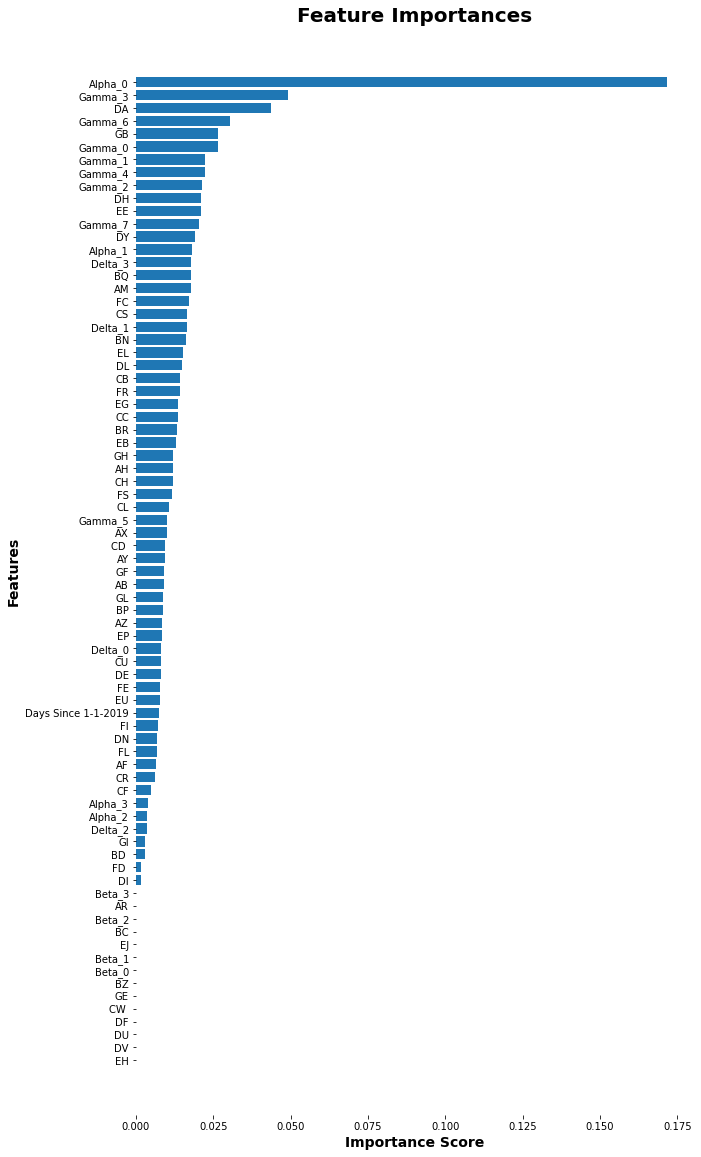

In [291]:
# plot feature importances
importances = pd.Series(xgb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [262]:
xtree = ExtraTreesClassifier(random_state = random_seed)

parameters = {
    'criterion': ['log_loss'],
    'n_estimators': [100],
    'max_depth': [9],
    'min_samples_split': [3],
    'max_features': ['sqrt']
}

grid_obj = GridSearchCV(xtree, parameters, scoring = balanced_log_loss_scorer, cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
xtree = grid_obj.best_estimator_
xtree.fit(X_train, y_train_class)

ExtraTreesClassifier(criterion='log_loss', max_depth=9, min_samples_split=3,
                     random_state=101010)

In [263]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.053239,0.007223,0.004611,0.000331,log_loss,9,sqrt,3,100,"{'criterion': 'log_loss', 'max_depth': 9, 'max...",-0.512572,-0.511582,-0.521375,-0.515176,0.004402,1


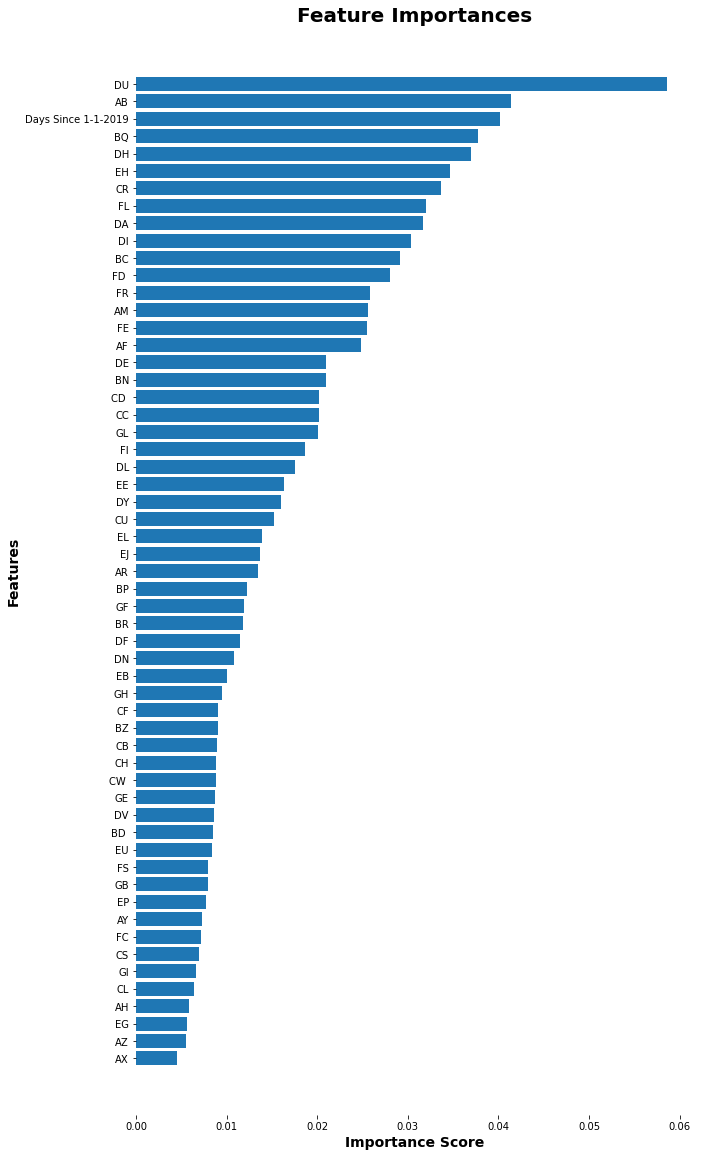

In [264]:
# plot feature importances
importances = pd.Series(xtree.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [584]:
tabpfn = TabPFNClassifier(seed = random_seed)

parameters = {
    'N_ensemble_configurations': [24]
}

grid_obj = GridSearchCV(tabpfn, parameters, scoring = 'roc_auc', cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
tabpfn = grid_obj.best_estimator_
tabpfn.fit(X_train, y_train_class)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier(N_ensemble_configurations=24, seed=101010)

In [585]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_N_ensemble_configurations,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001338,0.000163,1.506042,0.011642,24,{'N_ensemble_configurations': 24},0.46653,0.560109,0.490588,0.505742,0.039678,1


In [246]:
from sklearn.svm import SVC
svm = SVC(random_state = random_seed)

parameters = {
    'C': [3],
    'gamma': ['auto'],
    'kernel': ['rbf'],
    'probability': [True],
}

grid_obj = GridSearchCV(svm, parameters, scoring = balanced_log_loss_scorer, cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
svm = grid_obj.best_estimator_

# Fit the best estimator to the data
svm.fit(X_train, y_train_class)


SVC(C=3, gamma='auto', probability=True, random_state=101010)

In [247]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_probability,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015398,0.000628,0.003647,0.000222,3,auto,rbf,True,"{'C': 3, 'gamma': 'auto', 'kernel': 'rbf', 'pr...",-0.33431,-0.339342,-0.308012,-0.327221,0.013737,1


In [58]:
histboost = HistGradientBoostingClassifier(random_state = random_seed)

parameters = {
    'max_iter': [50],
    'learning_rate': [0.07],
    'min_samples_leaf': [20]
}

grid_obj = GridSearchCV(histboost, parameters, scoring = balanced_log_loss_scorer, cv = 3)
grid_obj = grid_obj.fit(X_train, y_train_class)
histboost = grid_obj.best_estimator_
histboost.fit(X_train, y_train_class)

HistGradientBoostingClassifier(learning_rate=0.07, max_iter=50,
                               random_state=101010)

In [59]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_iter,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.239994,0.020873,0.004053,0.001108,0.07,50,20,"{'learning_rate': 0.07, 'max_iter': 50, 'min_s...",-0.311517,-0.291274,-0.231357,-0.278049,0.034035,1


In [265]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Initialize CatBoostClassifier
catb = CatBoostClassifier(random_seed = random_seed, verbose=False)

# Define the parameter grid
parameters = {
    'depth': [6],
    'learning_rate': [0.05],
    'iterations': [100],
    'loss_function': ['Logloss'],
    'auto_class_weights': ['Balanced']
}

# Create a GridSearchCV object
grid_obj = GridSearchCV(catb, parameters, scoring = balanced_log_loss_scorer, cv = 3)

# Fit the GridSearchCV object to the data
grid_obj = grid_obj.fit(X_train, y_train_class)

# Get the best estimator
catb = grid_obj.best_estimator_

# Fit the best estimator to the data
catb.fit(X_train, y_train_class)


In [266]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_auto_class_weights,param_depth,param_iterations,param_learning_rate,param_loss_function,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.191667,0.005316,0.001988,0.00006,Balanced,6,100,0.05,Logloss,"{'auto_class_weights': 'Balanced', 'depth': 6,...",-0.362747,-0.308021,-0.281324,-0.317364,0.033891,1


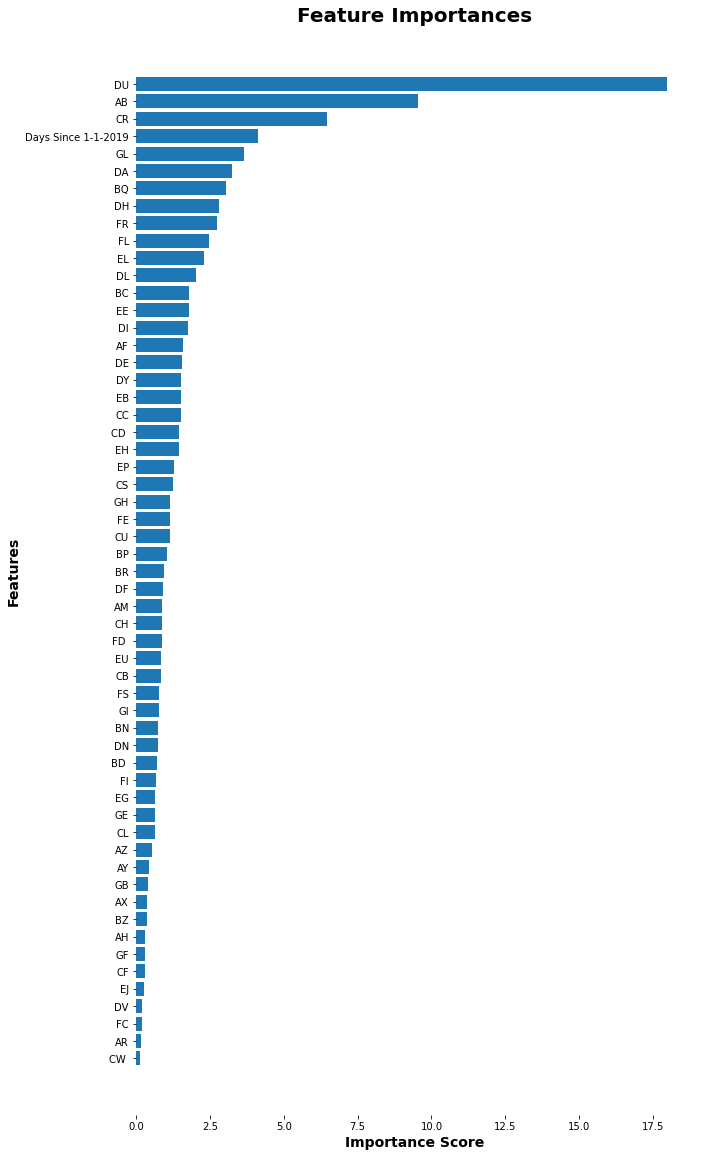

In [267]:
# plot feature importances
importances = pd.Series(catb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

# Alpha Prediction Features

### Model Prediction Features
KNN, Extra Trees, and TabPFN

In [145]:
def fit_model(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    model.fit(X, y)
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index=X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    
    return predictions_df

In [146]:
greek_prediction_cols = X_train.columns.to_list()

In [147]:
# alpha models
knn = KNeighborsClassifier(n_neighbors = 7)
svm = SVC(probability = True, random_state = random_seed)
extra_trees = ExtraTreesClassifier(n_estimators = 250, random_state = random_seed)
tabpfn = TabPFNClassifier(N_ensemble_configurations = 64, seed = random_seed)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [148]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_alpha[train_index], y_train_alpha[test_index]
    
    model_features = [
        'DU', 'CR', 'AB', 'DA', 'DH', 'BC', 'FR', 'EP', 'DI', 'FL', 'EU', 'EH', 'Days Since 1-1-2019'
    ]
    
    # fit models
    knn_features = model_features[0:3]
    knn_features.append(model_features[-1])
    
    knn_predictions = fit_model('KNN 7 Alpha', knn, fold, fold_y, oof, knn_features)
    svm_predictions = fit_model('SVM Alpha', svm, fold, fold_y, oof, model_features)
    extra_trees_predictions = fit_model('Extra Trees Alpha', extra_trees, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN Alpha', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([knn_predictions, svm_predictions, extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_alpha:
    X_train['Alpha_' + str(pred_class)] = X_train['Extra Trees Alpha_' + str(pred_class)] + X_train['TabPFN Alpha_' + str(pred_class)]

In [149]:
alpha_models = {
    'KNN 7': knn.fit(X_train[knn_features], y_train_alpha),
    'SVM': svm.fit(X_train[model_features], y_train_alpha),
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_alpha),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train_alpha)
}

In [150]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_beta)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_beta[train_index], y_train_beta[test_index]
    
    model_features = greek_prediction_cols.copy()
    
    # fit models
    extra_trees_predictions = fit_model('Extra Trees Beta', extra_trees, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN Beta', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_beta:
    X_train['Beta_' + str(pred_class)] = X_train['Extra Trees Beta_' + str(pred_class)] + X_train['TabPFN Beta_' + str(pred_class)]

In [151]:
beta_models = {
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_beta),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train_beta)
}

In [152]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_delta)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_delta[train_index], y_train_delta[test_index]
    
    model_features = greek_prediction_cols.copy()
    
    # fit models
    extra_trees_predictions = fit_model('Extra Trees Delta', extra_trees, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN Delta', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_delta:
    X_train['Delta_' + str(pred_class)] = X_train['Extra Trees Delta_' + str(pred_class)] + X_train['TabPFN Delta_' + str(pred_class)]
    
X_train.drop([
    'Extra Trees Delta_0', 'Extra Trees Delta_1', 'Extra Trees Delta_2', 'Extra Trees Delta_3', 
    'TabPFN Delta_0', 'TabPFN Delta_1', 'TabPFN Delta_2', 'TabPFN Delta_3'
], axis = 1, inplace = True)

In [153]:
delta_models = {
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_delta),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train_delta)
}

In [154]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_gamma)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_gamma[train_index], y_train_gamma[test_index]
    
    model_features = greek_prediction_cols.copy()
    
    # fit models
    extra_trees_predictions = fit_model('Extra Trees Gamma', extra_trees, fold, fold_y, oof, model_features)
    tabpfn_predictions = fit_model('TabPFN Gamma', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([extra_trees_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])
    
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_gamma:
    X_train['Gamma_' + str(pred_class)] = X_train['Extra Trees Gamma_' + str(pred_class)] + X_train['TabPFN Gamma_' + str(pred_class)]
    
X_train.drop([
    'Extra Trees Gamma_0', 'Extra Trees Gamma_1', 'Extra Trees Gamma_2', 'Extra Trees Gamma_3', 'Extra Trees Gamma_4', 'Extra Trees Gamma_5', 'Extra Trees Gamma_6', 'Extra Trees Gamma_7',
    'TabPFN Gamma_0', 'TabPFN Gamma_1', 'TabPFN Gamma_2', 'TabPFN Gamma_3', 'TabPFN Gamma_4', 'TabPFN Gamma_5', 'TabPFN Gamma_6', 'TabPFN Gamma_7'
], axis = 1, inplace = True)

In [155]:
gamma_models = {
    'Extra Trees': extra_trees.fit(X_train[model_features], y_train_gamma),
    'TabPFN': tabpfn.fit(X_train[model_features], y_train_gamma)
}

In [156]:
print('Shape of X:', X_train.shape)
print('Shape of y:', y_train_alpha.shape)

Shape of X: (473, 101)
Shape of y: (473,)


In [157]:
# print('Shape of X:', X_test.shape)
# print('Shape of y:', y_test.shape)

# Model Pipeline

In [158]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

In [159]:
X_train['Class'] = y_train_class
X_train['Alpha'] = y_train_alpha

In [160]:
# models
xgb = XGBClassifier(
    booster = 'gbtree',
    learning_rate = 0.02,
    n_estimators = 300,
    max_depth = 6,
    gamma = 0.3,
    min_child_weight = 2,
    max_delta_step = 1,
    subsample = 0.7,
    base_score = 0.85,
    n_jobs = -1, random_state = random_seed
)

catboost = CatBoostClassifier(
    iterations = 500,
    learning_rate = 0.05,
    depth = 7,
    loss_function = 'MultiClass',
    eval_metric = 'AUC',
    random_seed = random_seed,
    verbose = False,
)

tabpfn = TabPFNClassifier(
    N_ensemble_configurations = 64
)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [161]:
X_train.columns[: -68]

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY'],
      dtype='object')

In [162]:
y_true = []
y_pred = []
log_loss = []

skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y_class, oof_y_class = y_train_class[train_index], y_train_class[test_index]
    fold_y_alpha, oof_y_alpha = y_train_alpha[train_index], y_train_alpha[test_index]
    
    # over sample
    over_sampler = RandomOverSampler(random_state = random_seed)
    fold, fold_y_class = over_sampler.fit_resample(fold, fold_y_class)
    fold_y_alpha = fold['Alpha']
    fold.drop(['Alpha', 'Class'], axis = 1, inplace = True)
    oof.drop(['Alpha', 'Class'], axis = 1, inplace = True)
    
    # train models
    non_alpha_cols = [col for col in X_train.columns if 'Alpha' not in col]
    non_alpha_cols.remove('Class')
    
    xgb.fit(fold, fold_y_alpha)
    tabpfn.fit(fold[non_alpha_cols], fold_y_alpha)
    
    # predict oof
    oof_y_alpha_proba = xgb.predict_proba(oof)
    oof_y_alpha_proba += tabpfn.predict_proba(oof[non_alpha_cols])
    oof_y_alpha_proba /= 2
    
    class_0 = oof_y_alpha_proba[:, 0].sum()
    class_123 = oof_y_alpha_proba[:, 1:].sum()
    new_probabilities = oof_y_alpha_proba * np.array([[1/(class_0 if i == 0 else class_123) for i in range(oof_y_alpha_proba.shape[1])]])
    oof_y_alpha_proba =  new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
    
    oof_y_class_proba = oof_y_alpha_proba[:, 1:].sum(axis = 1)
    # oof_y_class_proba[oof_y_class_proba > 0.95] = 1
    # oof_y_class_proba[oof_y_class_proba < 0.025] = 0
    
    fold_log_loss = competition_log_loss(oof_y_class, oof_y_class_proba)
    log_loss.append(fold_log_loss)
    
    print('Balanced Log Loss:', fold_log_loss)
    y_true.append(oof_y_class)
    y_pred.append(oof_y_class_proba)

81
Balanced Log Loss: 0.12314293729268876
81
Balanced Log Loss: 0.24797380812598277
81
Balanced Log Loss: 0.16025999144270348
81
Balanced Log Loss: 0.27208488957378996
81
Balanced Log Loss: 0.10073736062200327


In [163]:
np.mean(log_loss)

0.18083979741143363

In [164]:
max_pred = [
    0.75, 0.76, 0.77, 0.78, 0.79, 
    0.80, 0.81, 0.82, 0.83, 0.84, 
    0.85, 0.86, 0.87, 0.88, 0.89, 
    0.90, 0.91, 0.92, 0.93, 0.94, 
    0.95, 0.96, 0.97, 0.98, 0.99,
    1.00
]
min_pred = [
    0.00, 0.01, 0.02, 0.03, 0.04, 
    0.05, 0.06, 0.07, 0.08, 0.09, 
    0.10, 0.11, 0.12, 0.13, 0.14, 
    0.15, 0.16, 0.17, 0.18, 0.19, 
    0.20, 0.21, 0.22, 0.23, 0.24, 
    0.25
]

optimal_thresholds = pd.DataFrame({}, columns = ['Max', 'Min', 'Log Loss'])
for max_v in max_pred:
    for min_v in min_pred:
        for i in range(len(y_pred)):
            fold_pred = y_pred[i].copy()
            fold_true = y_true[i].copy()
            
            fold_pred[fold_pred > max_v] = 1
            fold_pred[fold_pred < min_v] = 0
            
            loss = competition_log_loss(fold_true, fold_pred)
            
            # add to dataframe
            new_row = pd.DataFrame({'Max': [max_v], 'Min': [min_v], 'Log Loss': [loss]})
            optimal_thresholds = pd.concat([optimal_thresholds, new_row], ignore_index = True)

In [165]:
optimal_thresholds.groupby(['Max', 'Min']).mean().sort_values('Log Loss', ascending = True).head(10)

Log Loss
Max  Min           
0.98 0.01  0.179543
     0.00  0.179596
0.99 0.01  0.180017
     0.00  0.180070
1.00 0.01  0.180787
     0.00  0.180840
0.93 0.01  0.260345
     0.00  0.260397
0.94 0.01  0.261577
     0.00  0.261630

In [169]:
X_train.drop(['Class', 'Alpha'], axis = 1, inplace = True)

In [170]:
xgb = XGBClassifier(
    booster = 'gbtree',
    learning_rate = 0.02,
    n_estimators = 300,
    max_depth = 6,
    gamma = 0.3,
    min_child_weight = 2,
    max_delta_step = 1,
    subsample = 0.7,
    base_score = 0.85,
    n_jobs = -1, random_state = random_seed
)

In [171]:
xgb.fit(X_train, y_train_class)

XGBClassifier(base_score=0.85, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=101010, reg_alpha=0, reg_lambda=1, ...)

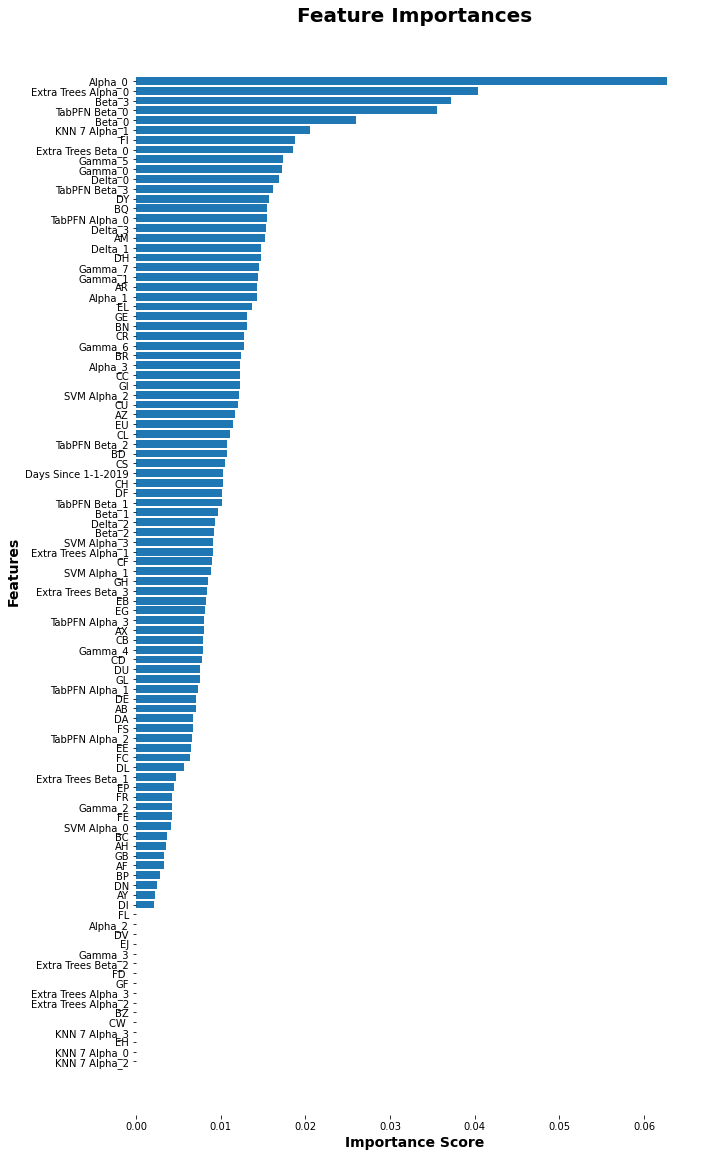

In [172]:
importances = pd.Series(xgb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()